# Forecasting NHS staff turnover using Prophet

Data from NHS Digital (Legacy) Workforce Statistics, "Turnover from organisation benchmarking source data, October 2022" https://digital.nhs.uk/data-and-information/publications/statistical/nhs-workforce-statistics/october-2022  
Excel PowerQuery used to wrangle data into usable format.

## Load and explore data

Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from prophet import Prophet

import prophet

#should be version 1.0 according to course but that is not working so trying with latest
prophet.__version__

'1.1.2'

In [3]:
from forecast_tools.model_selection import auto_naive
from forecast_tools.metrics import mean_absolute_error

Load in data (pre-processed), rename some columns and then look at info about loaded data and top 5 rows.

In [5]:
url = '../02_data/2023-01_turnover_monthly_csv.csv'
pr_y_train = pd.read_csv(url, parse_dates=['Date'], 
                            dayfirst=True)
                         #,index_col='Date')
pr_y_train.rename(columns={'SIP.FTE':'SIP_FTE','SIP.HC':'SIP_HC'},inplace=True)
pr_y_train['Date'] = pd.to_datetime(pr_y_train['Date'])
#df = df.set_index(['Date', 'Staff group', 'Org code'])
pr_y_train = pr_y_train.sort_values(by='Date')
pr_y_train.info()
#pr_y_train.index.freq = 'D'

<class 'pandas.core.frame.DataFrame'>
Int64Index: 228976 entries, 0 to 228975
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Date              228976 non-null  datetime64[ns]
 1   Type              228976 non-null  object        
 2   Org code          228976 non-null  object        
 3   Org name          228976 non-null  object        
 4   NHSE region code  228976 non-null  object        
 5   NHSE region name  228976 non-null  object        
 6   ICS code          228976 non-null  object        
 7   ICS name          228976 non-null  object        
 8   Cluster group     228976 non-null  object        
 9   Benchmark group   228976 non-null  object        
 10  Staff group       228976 non-null  object        
 11  HC                228976 non-null  int64         
 12  FTE               228976 non-null  float64       
 13  SIP_HC            228017 non-null  float64       
 14  SIP_

In [6]:
pr_y_train.head()

,Date,Type,Org code,Org name,NHSE region code,NHSE region name,ICS code,ICS name,Cluster group,Benchmark group,Staff group,HC,FTE,SIP_HC,SIP_FTE
0,2018-08-01,Joiners,RVV,East Kent Hospitals University NHS Foundation ...,Y59,South East,QKS,Kent and Medway,Acute,Acute - Teaching,Managers,8,7.67500,108.0,105.15500
2710,2018-08-01,Leavers,RV5,South London and Maudsley NHS Foundation Trust,Y56,London,QKK,South East London,Mental Health,Mental Health and Learning Disability,HCHS doctors (exc. junior Drs),5,4.05195,248.0,218.53954
2711,2018-08-01,Joiners,RBZ,Northern Devon Healthcare NHS Trust,Y58,South West,QJK,Devon,Acute,Acute - Small,All staff groups,58,51.97166,2984.0,2497.48221
2712,2018-08-01,Joiners,RV5,South London and Maudsley NHS Foundation Trust,Y56,London,QKK,South East London,Mental Health,Mental Health and Learning Disability,HCHS doctors (exc. junior Drs),5,4.00000,248.0,218.53954
2713,2018-08-01,Joiners,07H,NHS West Essex CCG,Y61,East of England,QM7,Hertfordshire and West Essex,Clinical Commissioning Group,Clinical Commissioning Group,Nurses & health visitors,2,1.21333,18.0,13.88666


The data show the full time equivalent (FTE) and headcount (HC) number of leavers and joiners by organisation and staff group for the previous 12-month period from the date. It also shows the number of staff in post (SIP) HC and FTE averaged over the 12-month period to date.

Drop joiners data to create leavers dataframe. Then drop some staff groups not of interest and drop CCGs and ICBs.

In [7]:
df_leaver = pr_y_train[pr_y_train.Type == 'Leavers']


staff_groups_todrop = ['Other staff or those with unknown classification','Managers','Senior managers','Central functions','Hotel, property & estates']
df_leaver = df_leaver[~df_leaver['Staff group'].isin(staff_groups_todrop)]

trust_types_todrop = ['Clinical Commissioning Group','Integrated Care Board']
df_leaver_trusts = df_leaver[~df_leaver['Cluster group'].isin(trust_types_todrop)]

df_leaver_acute = df_leaver[df_leaver['Cluster group'] == 'Acute']

df_leaver_trusts.head()

df_leaver.head()

,Date,Type,Org code,Org name,NHSE region code,NHSE region name,ICS code,ICS name,Cluster group,Benchmark group,Staff group,HC,FTE,SIP_HC,SIP_FTE
2710,2018-08-01,Leavers,RV5,South London and Maudsley NHS Foundation Trust,Y56,London,QKK,South East London,Mental Health,Mental Health and Learning Disability,HCHS doctors (exc. junior Drs),5,4.05195,248.0,218.53954
2714,2018-08-01,Leavers,RVV,East Kent Hospitals University NHS Foundation ...,Y59,South East,QKS,Kent and Medway,Acute,Acute - Teaching,"Support to doctors, nurses & midwives",32,28.48508,2049.0,1773.41754
2719,2018-08-01,Leavers,RXA,Cheshire and Wirral Partnership NHS Foundation...,Y62,North West,QYG,Cheshire and Merseyside,Mental Health,Mental Health and Learning Disability,"Support to doctors, nurses & midwives",17,14.42000,913.0,777.65168
2720,2018-08-01,Leavers,00V,NHS Bury CCG,Y62,North West,QOP,Greater Manchester,Clinical Commissioning Group,Clinical Commissioning Group,All staff groups,2,2.00000,96.0,73.91734
2724,2018-08-01,Leavers,RQY,South West London and St George's Mental Healt...,Y56,London,QWE,South West London,Mental Health,Mental Health and Learning Disability,"Scientific, therapeutic & technical staff",9,7.80000,397.0,324.52144


Dataframe of one org for testing

In [8]:
org = 'RAE'

df_org = df_leaver[df_leaver['Org code']==org]

df_org = df_org.groupby(['Date','Staff group']).agg({'FTE':'sum','SIP_FTE':'sum','HC':'sum','SIP_HC':'sum'})
df_org['rate'] = df_org['FTE']/df_org['SIP_FTE']
#df_org

Graph of "all staff" leaver rate in the one testing org over time.

In [88]:
#_ = sg_df['rate'].plot(figsize=(15,6))
#df_org.unstack(level=1)['rate']['All staff groups'].plot(figsize=(15,6))

# set the x-axis and y-axis labels
#plt.xlabel('Date')
#plt.ylabel('Rate')
#plt.legend(title='Staff Group')

# display the plot
#plt.show()

Create a new dataframe where dependent variables are aggregated up by date and staff group and add a "rate" column

In [9]:
df_leaver_sg_national = df_leaver.groupby(['Date','Staff group']).agg({'FTE':'sum','SIP_FTE':'sum','HC':'sum','SIP_HC':'sum'})
df_leaver_sg_national['rate'] = df_leaver_sg_national['FTE']/df_leaver_sg_national['SIP_FTE']
df_leaver_sg_national

FTE  \
Date       Staff group                                              
2018-08-01 All staff groups                           12437.76030   
           Ambulance staff                              189.33106   
           HCHS doctors (exc. junior Drs)               736.08561   
           Midwives                                     225.08126   
           Nurses & health visitors                    3214.72794   
...                                                           ...   
2023-01-01 Nurses & health visitors                    4046.49487   
           Scientific, therapeutic & technical staff   2260.95829   
           Support to ST&T staff                       1204.39617   
           Support to ambulance staff                   341.81665   
           Support to doctors, nurses & midwives       3993.63185   

                                                           SIP_FTE     HC  \
Date       Staff group                                                      
2018-08-01 All staff groups                           951687.60600  14577   
           Ambulance staff                             20500.08605    210   
           HCHS doctors (exc. junior Drs)              51582.93875    871   
           Midwives                                    18213.75542    277   
           Nurses & health visitors                   266687.21646   3697   
...                                                            ...    ...   
2023-01-01 Nurses & health visitors                   340498.73102   4722   
           Scientific, therapeutic & technical staff  165618.21866   2582   
           Support to ST&T staff                       78884.99983   1373   
           Support to ambulance staff                  25906.07009    398   
           Support to doctors, nurses & midwives      293538.66495   4784   

                                                         SIP_HC      rate  
Date       Staff group                                                     
2018-08-01 All staff groups                           1086626.0  0.013069  
           Ambulance staff                              21791.0  0.009236  
           HCHS doctors (exc. junior Drs)               56788.0  0.014270  
           Midwives                                     22094.0  0.012358  
           Nurses & health visitors                    299807.0  0.012054  
...                                                         ...       ...  
2023-01-01 Nurses & health visitors                    378329.0  0.011884  
           Scientific, therapeutic & technical staff   188650.0  0.013652  
           Support to ST&T staff                        89407.0  0.015268  
           Support to ambulance staff                   28309.0  0.013194  
           Support to doctors, nurses & midwives       338709.0  0.013605  

[486 rows x 5 columns]

Create a new dataframe where dependent variables are aggregated up by date and staff group and add a "rate" column

In [10]:
df_leaver_trusts_sg = df_leaver_trusts.groupby(['Date','Staff group']).agg({'FTE':'sum','SIP_FTE':'sum','HC':'sum','SIP_HC':'sum'})
df_leaver_trusts_sg['rate'] = df_leaver_trusts_sg['FTE']/df_leaver_trusts_sg['SIP_FTE']


#sg_df.set_index('Date')
df_leaver_trusts_sg.head()
#_ = leaver_df.groupby('Staff group')['FTE'].plot(figsize=(12,4),legend=True)

FTE       SIP_FTE     HC  \
Date       Staff group                                                        
2018-08-01 All staff groups                12311.42991  945012.84769  14432   
           Ambulance staff                   189.33106   20500.08605    210   
           HCHS doctors (exc. junior Drs)    735.13006   51574.58046    867   
           Midwives                          225.08126   18213.75542    277   
           Nurses & health visitors         3201.72127  266289.12818   3681   

                                              SIP_HC      rate  
Date       Staff group                                          
2018-08-01 All staff groups                1079000.0  0.013028  
           Ambulance staff                   21791.0  0.009236  
           HCHS doctors (exc. junior Drs)    56758.0  0.014254  
           Midwives                          22094.0  0.012358  
           Nurses & health visitors         299343.0  0.012023

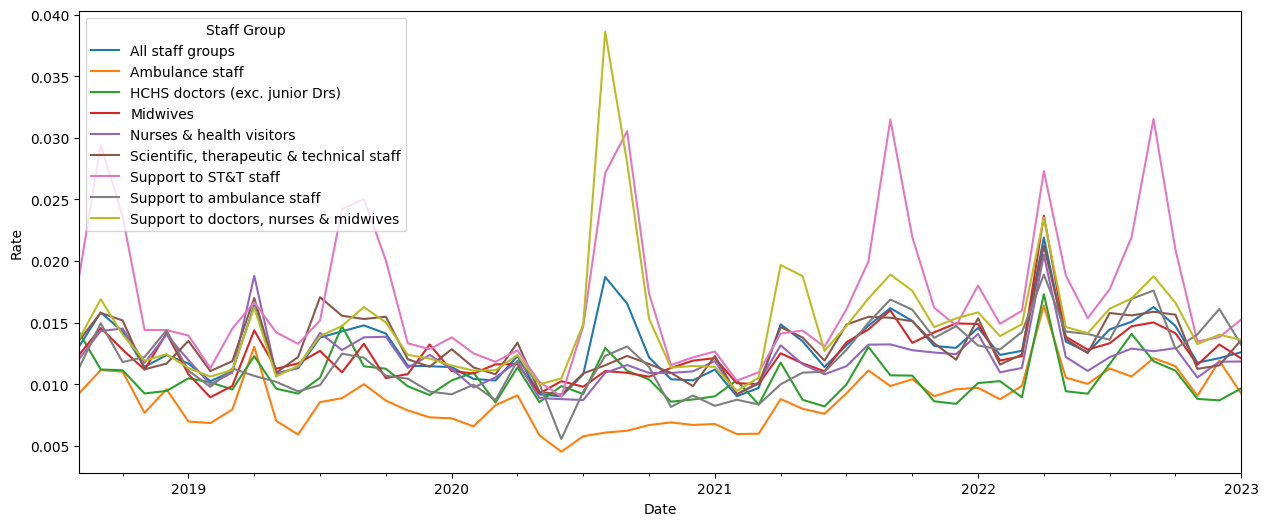

In [11]:
#_ = sg_df['rate'].plot(figsize=(15,6))
df_leaver_trusts_sg.unstack(level=1)['rate'].plot(figsize=(15,6))

# set the x-axis and y-axis labels
plt.xlabel('Date')
plt.ylabel('Rate')
plt.legend(title='Staff Group')

# display the plot
plt.show()

Did the coding of Ambulance staff and Support to ambulance staff change at some point, explaining the strange patterns Mar-2019 to Mar-2020?

In [12]:
#_ = sg_df['rate'].plot(figsize=(15,6))

staff_groups_toplot = ['All staff groups','Midwives','Nurses & health visitors']
df_leaver_sg_toplot = df_leaver[df_leaver['Staff group'].isin(staff_groups_toplot)]

df_leaver_sg_toplot = df_leaver_sg_toplot.groupby(['Date','Staff group']).agg({'FTE':'sum','SIP_FTE':'sum','HC':'sum','SIP_HC':'sum'})
df_leaver_sg_toplot['rate'] = df_leaver_sg_toplot['FTE']/df_leaver_sg_toplot['SIP_FTE']

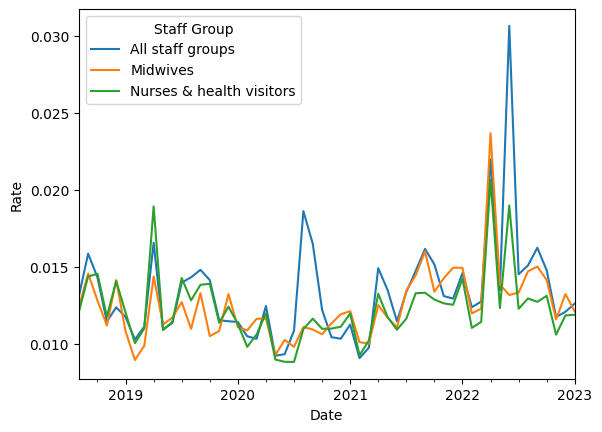

In [13]:
df_leaver_sg_toplot.unstack(level=1)['rate'].plot.line()

# set the x-axis and y-axis labels
plt.xlabel('Date')
plt.ylabel('Rate')
plt.legend(title='Staff Group')

# display the plot
plt.show()

## Put data into format suitable for Prophet forecasting

Take the rate column from the dataframe plotted above and specify one staff group. y\_train contains national level leaver rates by month for specified staff group then convert to dataframe.

In [14]:
staff_group = 'Midwives'

y_train = df_leaver_trusts_sg.unstack(level=1)['rate'][staff_group]
y_train.head()

Date
2018-08-01    0.012358
2018-09-01    0.014565
2018-10-01    0.012803
2018-11-01    0.011189
2018-12-01    0.014139
Name: Midwives, dtype: float64

In [15]:
#y_train.set_index('Date')
y_train = y_train.to_frame()
#y_train['turnover rate'] = y_train['All staff groups']
y_train.head()

,Midwives
Date,
2018-08-01,0.012358
2018-09-01,0.014565
2018-10-01,0.012803
2018-11-01,0.011189
2018-12-01,0.014139


The below function converts the training data into the correct format for Prophet giving a dataframe with 2 columns: 'ds': the date; 'y': the leaver rate.

In [16]:
def prophet_training_data(y_train):
    '''
    Converts a standard pandas datetimeindexed dataframe
    for time series into one suitable for Prophet
    Parameters:
    ---------
    y_train: pd.DataFrame
        univariate time series data
        
    Returns:
    --------
        pd.DataFrame in Prophet format 
        columns = ['ds', 'y']
    '''
    prophet_train = pd.DataFrame(y_train.index)
    prophet_train['y'] = y_train.to_numpy()
    prophet_train.columns = ['ds', 'y']

    return prophet_train

Apply function to our data

In [17]:
yp_train = prophet_training_data(y_train)

In [18]:
yp_train.tail()

,ds,y
49,2022-09-01,0.015017
50,2022-10-01,0.014141
51,2022-11-01,0.011580
52,2022-12-01,0.013231
53,2023-01-01,0.012090


## Fit and predict data with Prophet

Create the first Prophet object called 'model', with a 95% interval width. Apply to our data.

In [19]:
#model = Prophet(interval_width=0.95,
#               seasonality_mode='multiplicative')

model = Prophet(interval_width=0.95)
model.fit(yp_train)

17:37:58 - cmdstanpy - INFO - Chain [1] start processing
17:37:59 - cmdstanpy - INFO - Chain [1] done processing


Specify monthly data here in the frequency (freq='MS')

In [20]:
future = model.make_future_dataframe(periods=24, freq='MS')
future

,ds
0,2018-08-01
1,2018-09-01
2,2018-10-01
3,2018-11-01
4,2018-12-01
...,...
73,2024-09-01
74,2024-10-01
75,2024-11-01
76,2024-12-01


In [21]:
prophet_forecast = model.predict(future)
prophet_forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
73,2024-09-01,0.016144,0.014088,0.020084,0.015870,0.016424,0.000784,0.000784,0.000784,0.000784,0.000784,0.000784,0.0,0.0,0.0,0.016928
74,2024-10-01,0.016229,0.012924,0.018526,0.015936,0.016535,-0.000463,-0.000463,-0.000463,-0.000463,-0.000463,-0.000463,0.0,0.0,0.0,0.015766
75,2024-11-01,0.016316,0.013142,0.018912,0.016007,0.016643,-0.000403,-0.000403,-0.000403,-0.000403,-0.000403,-0.000403,0.0,0.0,0.0,0.015913
76,2024-12-01,0.016401,0.013657,0.019460,0.016074,0.016751,-0.000098,-0.000098,-0.000098,-0.000098,-0.000098,-0.000098,0.0,0.0,0.0,0.016303
77,2025-01-01,0.016488,0.013944,0.019525,0.016141,0.016865,0.000216,0.000216,0.000216,0.000216,0.000216,0.000216,0.0,0.0,0.0,0.016704


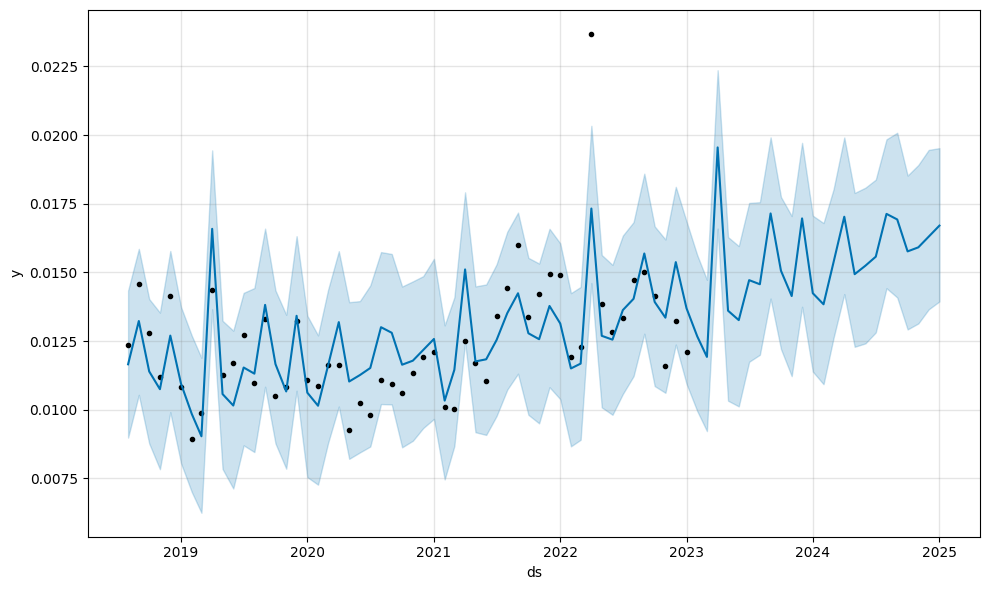

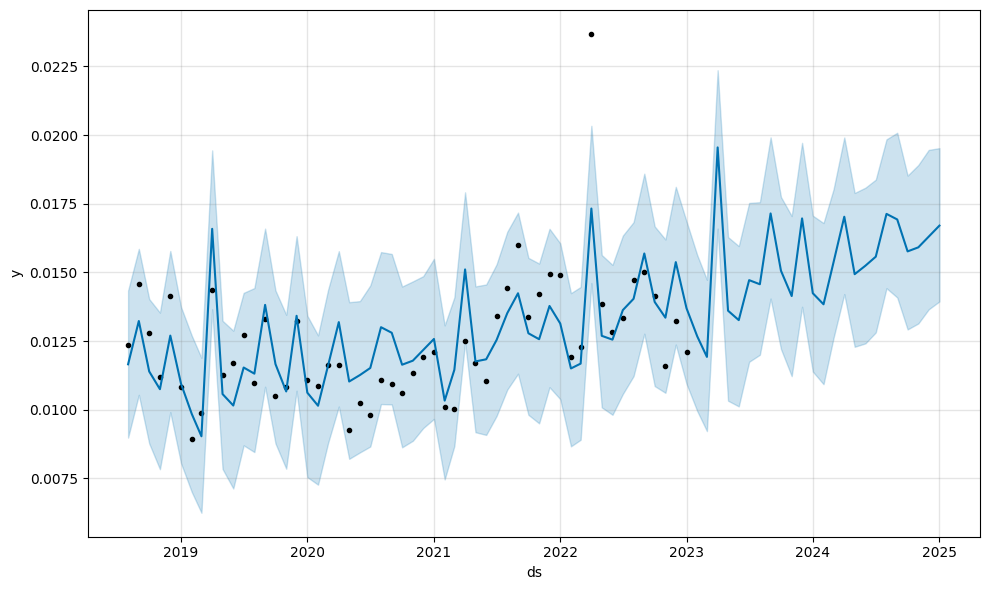

In [22]:
model.plot(prophet_forecast)

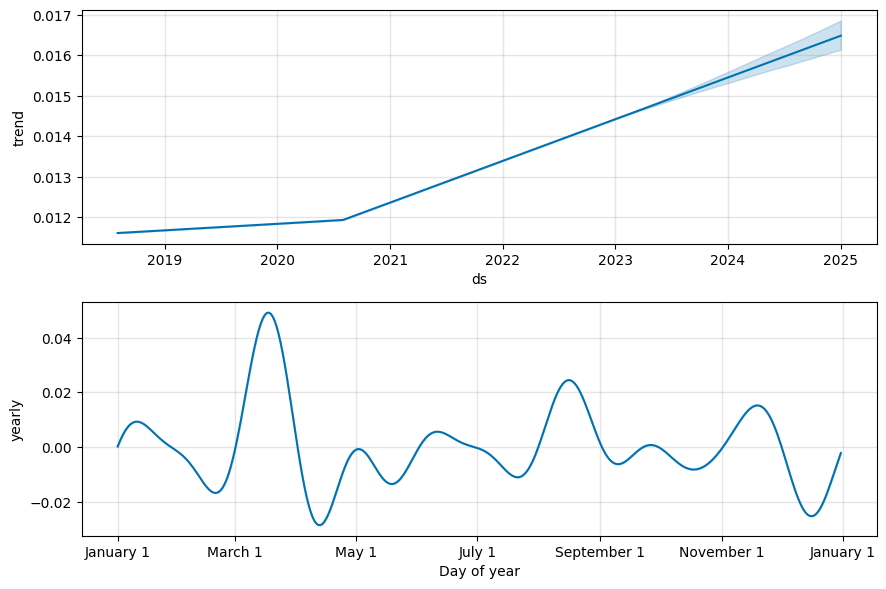

In [24]:
_ = model.plot_components(prophet_forecast)

## Adding changepoints to Prophet

Changepoints are the datetime points where the time series have abrupt changes in the trajectory.

Let’s plot the vertical lines where the potential changepoints occurred

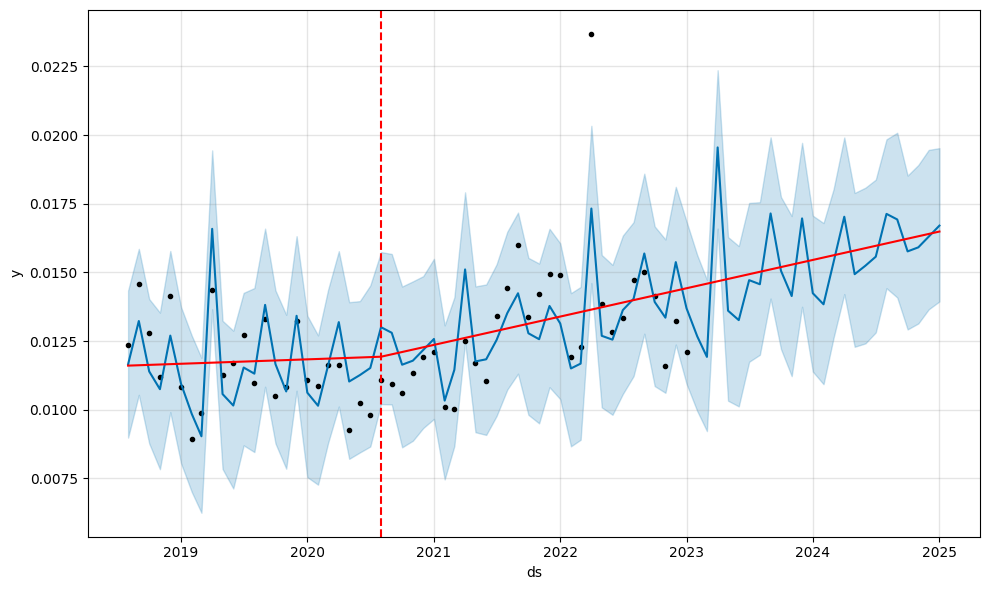

In [25]:
from prophet.plot import add_changepoints_to_plot
fig = model.plot(prophet_forecast)
a = add_changepoints_to_plot(fig.gca(), model, prophet_forecast)

In [26]:
model.changepoints

2    2018-10-01
3    2018-11-01
5    2019-01-01
7    2019-03-01
8    2019-04-01
10   2019-06-01
12   2019-08-01
13   2019-09-01
15   2019-11-01
17   2020-01-01
18   2020-02-01
20   2020-04-01
22   2020-06-01
24   2020-08-01
25   2020-09-01
27   2020-11-01
29   2021-01-01
30   2021-02-01
32   2021-04-01
34   2021-06-01
35   2021-07-01
37   2021-09-01
39   2021-11-01
40   2021-12-01
42   2022-02-01
Name: ds, dtype: datetime64[ns]

We can change the inferred changepoint range by setting the changepoint\_range, the number of changepoints with n\_changepoints, and changepoint\_prior\_scale to adjust the trend. 

Default value for changepoint\_prior\_scale is 0.05. Decrease the value to make the trend less flexible. Increase the value of changepoint\_prior\_scale to make the trend more flexible.

17:38:35 - cmdstanpy - INFO - Chain [1] start processing
17:38:36 - cmdstanpy - INFO - Chain [1] done processing


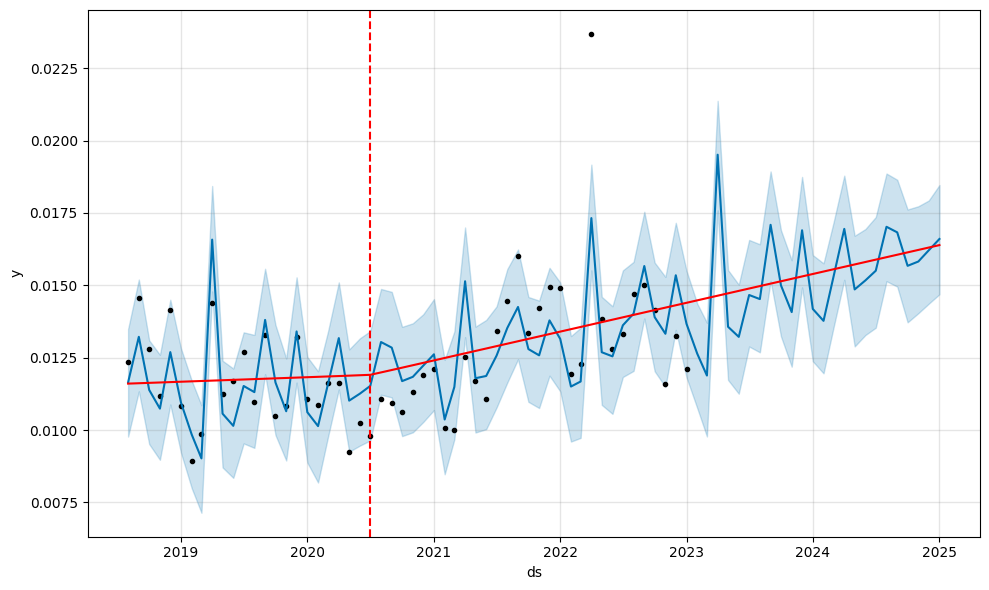

In [27]:
#pro_change = Prophet(changepoint_range=0.9)

model_1 = Prophet(n_changepoints = 45, changepoint_range=0.9, changepoint_prior_scale=0.05, yearly_seasonality = True)


prophet_forecast_1 = model_1.fit(yp_train).predict(future)
fig= model_1.plot(prophet_forecast_1)
a = add_changepoints_to_plot(fig.gca(), model_1, prophet_forecast_1)


## Adding events (and COVID)

## Adding mutliple regressors

https://towardsdatascience.com/time-series-prediction-using-prophet-in-python-35d65f626236

Additional regressors can be added to the Prophet model. This is done by using add\_regressor. Additional regressor column value needs to be present in both the fitting as well as prediction dataframes.

  

Creating fitting and predicting dataset with additional regressors

In [ ]:
train_dataset[‘type’] = X[‘type’]
train_dataset[‘Total Volume’] = X[‘Total Volume’]
train_dataset[‘4046’] = X[‘4046’]
train_dataset[‘4225’] = X[‘4225’]
train_dataset[‘4770’] = X[‘4770’]
train_dataset[‘Small Bags’] = X[‘Small Bags’]
train_X= train_dataset[:18000]
test_X= train_dataset[18000:]

## Evaluating model fit

Take from prophet\_exercises\_SOLUTIONS

In [117]:
yp_train = prophet_training_data(y_train[:-28])
yp_test = prophet_training_data(y_train[-28:])

In [118]:
print(y_train.shape)

(54, 1)


In [119]:
print(yp_train.shape)

(26, 2)


In [120]:
print(yp_test.shape)

(28, 2)


In [121]:
import numpy as np
from forecast_tools.datasets import load_emergency_dept
from forecast_tools.model_selection import auto_naive 

In [122]:
best = auto_naive(y_train[:-28], horizon=15)
best

{'model': Drift(), 'mae': 0.004898441946590462}

In [123]:
from forecast_tools.baseline import EnsembleNaive

ens = EnsembleNaive(1)
ens_preds = ens.fit_predict(y_train[:-28], horizon=28)

In [124]:
model = Prophet(interval_width=0.95, daily_seasonality=False)
model.add_country_holidays(country_name='UK')
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model.fit(yp_train)
future = model.make_future_dataframe(periods=28,freq='MS')
prophet_forecast = model.predict(future)
#_ = model.plot_components(prophet_forecast);

14:54:39 - cmdstanpy - INFO - Chain [1] start processing
14:54:43 - cmdstanpy - INFO - Chain [1] done processing


In [125]:
from forecast_tools.metrics import forecast_errors # creates range of forecast errors
# below is forecast errors for SNaive
# ~12% error
forecast_errors(y_train[-28:], prophet_forecast['yhat'].iloc[-28:].to_list())

{'me': 0.05756040611521075,
 'mae': 0.05843443694258562,
 'mse': 0.004727536496100446,
 'rmse': 0.06875708324311355,
 'mape': 51.270960976628146,
 'smape': 81.12050246524355}

In [126]:
forecast_errors(y_train[-28:], ens_preds)

{'me': 0.016716987087863785,
 'mae': 0.01892564427635774,
 'mse': 0.0005368297588399821,
 'rmse': 0.023169586937189495,
 'mape': 15.561613684743639,
 'smape': 17.39688202238102}